In [195]:
from pyomo . environ import *
import pandas as pd
import geopy . distance
from geopy . distance import geodesic
import networkx as nx
import matplotlib . pyplot as plt

In [196]:
import os
import numpy as np
import numpy as np
import pandas as pd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString
from osmnx.features import features_from_polygon
from collections import defaultdict

In [197]:
gdf = ox.geocode_to_gdf("Provincia di Brescia, Lombardia, Italia")
province_gdf = gdf.to_crs(epsg=3857)


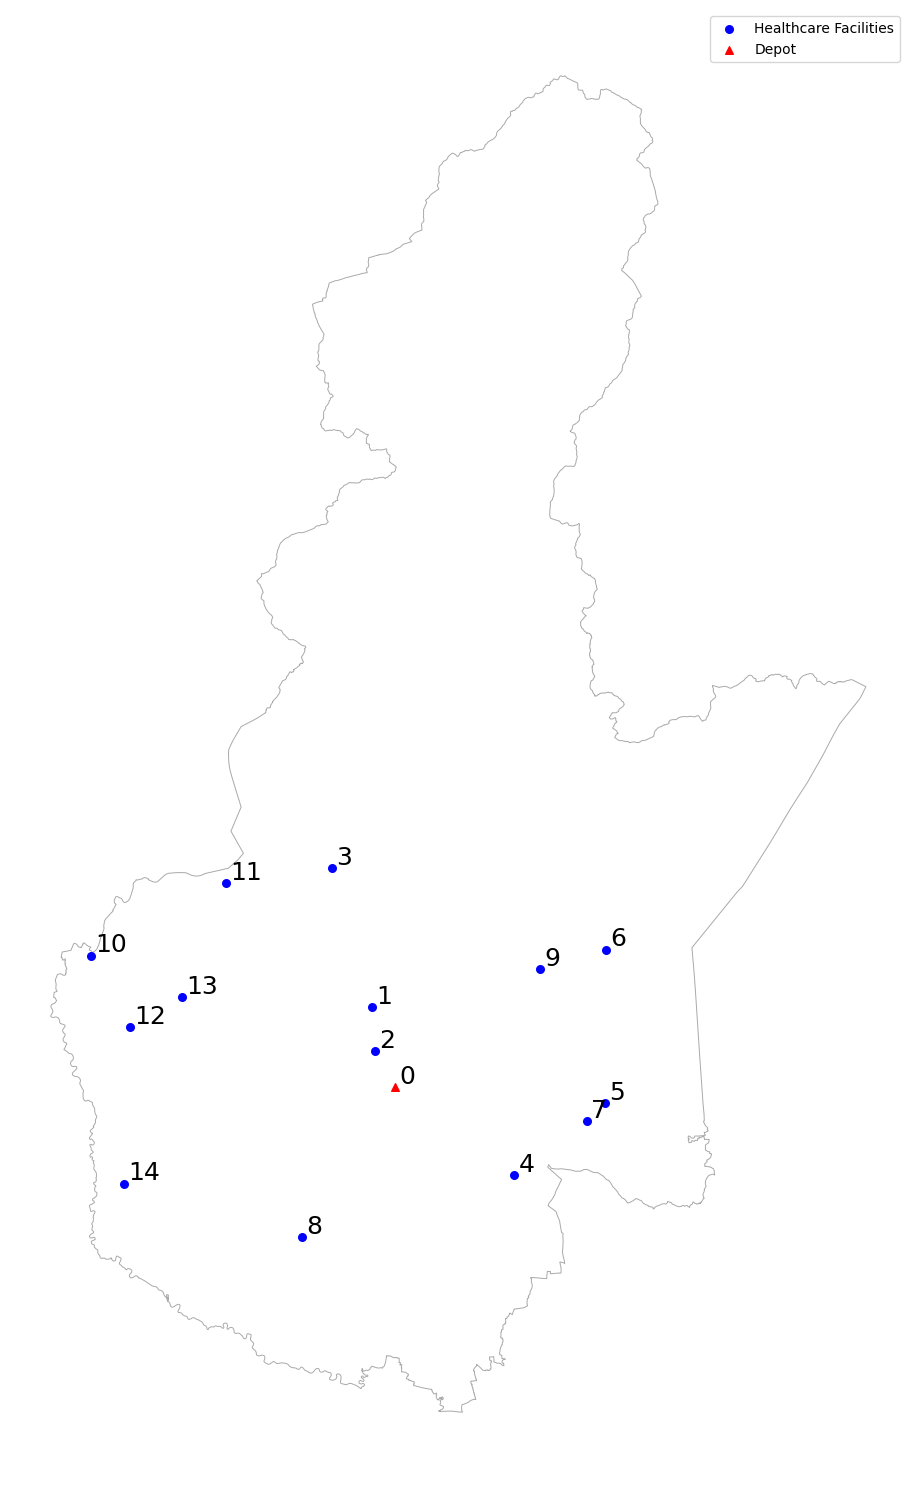

In [198]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd

# Dati
lats = [45.5557508, 45.5173032, 45.6752766, 45.4104244, 45.4724484, 45.6052090,
        45.4570527, 45.3564514, 45.5886191, 45.6000908, 45.6629423, 45.5380671,
        45.5643032, 45.4027300]
lons = [10.2333866, 10.2367065, 10.1838538, 10.4087873, 10.5210075, 10.5222784,
        10.4981922, 10.1459897, 10.4399889, 9.8859103, 10.0521876, 9.9340234,
        9.9981402, 9.9265984]

# Nomi degli ospedali (approssimati)
hospital_names = [
    "Ospedale Civile di Brescia (ASST Brescia)",
    "Poliambulanza",
    "Ospedale di Gardone Val Trompia(ASST Brescia)",
    "Ospedale di Montichiari (ASST Brescia)",
    "Ospedale di Desenzano del Garda(ASST del Garda)",
    "Ospedale di Salo (ASST del Garda)",
    "Ospedale di Lonato del Garda (ASST del Garda)",
    "Ospedale di Manerbio (ASST Garda)",
    "Ospedale di Gavardo (ASST del Garda)",
    "Ospedale di Palazzolo sull'Oglio (ASST Franciacorta)",
    "Ospedale di Iseo (ASST Franciacorta)",
    "Ospedale di Chiari (ASST Franciacorta)",
    "Ospedale di Rovato (ASST Franciacorta)",
    "Ospedale di Orzinuovi(ASST Franciacorta)"
]

ids = list(range(1, 15))

depot_lat = 45.486074
depot_lon = 10.261607

# Crea geometrie
facility_points = [Point(lon, lat) for lon, lat in zip(lons, lats)]
depot_point = Point(depot_lon, depot_lat)

# Crea GeoDataFrame
facilities_gdf = facilities_gdf = gpd.GeoDataFrame({
    'ID': ids,
    'Name': hospital_names,
    'geometry': facility_points
}, crs="EPSG:4326").to_crs(epsg=3857)


depot_gdf = gpd.GeoDataFrame({
    'ID': [0],
    'Name': ['Depot'],
    'geometry': [Point(depot_lon, depot_lat)]
}, crs="EPSG:4326").to_crs(epsg=3857)

# Unisci se ti serve avere un unico GDF
all_nodes_gdf = pd.concat([depot_gdf, facilities_gdf], ignore_index=True)
# Crea la mappa
fig, ax = plt.subplots(figsize=(15, 15))

province_gdf.plot(ax=ax, facecolor='none', edgecolor='darkgray', linewidth=0.7)

# Plotta le strade (supponendo EPSG:3857)
#roads_gdf.to_crs(epsg=3857).plot(ax=ax, color='lightgrey', linewidth=0.3)

# Plotta i punti (strutture sanitarie)
facilities_gdf.plot(ax=ax, color='blue', marker='o', markersize=30, label='Healthcare Facilities',zorder=2)

for idx, row in facilities_gdf.iterrows():
    ax.annotate(text=str(row['ID']), xy=(row.geometry.x, row.geometry.y),
                xytext=(3, 3), textcoords="offset points", fontsize=18, color='black')

ax.annotate(text='0', xy=(depot_gdf.geometry.x[0], depot_gdf.geometry.y[0]),
            xytext=(3, 3), textcoords="offset points", fontsize=18, color='black')

# Plotta il deposito come stellina rossa
depot_gdf.plot(ax=ax, color='red', marker='^', markersize=30, label='Depot',zorder=2)

# Titolo e layout
#ax.set_title("Target Healthcare Facilities and Depot Location", fontsize=14)
ax.axis("off")
ax.legend()
plt.tight_layout()
plt.show()

In [199]:
file_path = "/Users/francescavasta/Desktop/ADSEM/II YEAR II SEM/Optimization Methods/project/cost_matrix.xlsx"

In [200]:
def reOrderPath (solution , solutionPoints , Nodes) :
    Depot = Nodes[0]
    DepotReturn = Nodes [ len( Nodes ) -1]
    node = Depot
    solutionOrdered =[]
    solutionPointsOrdered =[]
    while node != DepotReturn :
        solutionPointsOrdered . append ( node )
        for arc in solution :
            a = arc [0]
            b = arc [1]
            if a == node :
                solutionOrdered . append ( arc )
                node = b
                break
    solutionPointsOrdered . append ( DepotReturn )
    return solutionOrdered , solutionPointsOrdered

In [201]:
def load_all_daily_dictionaries(file_path):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_dicts = []

    for i, day in enumerate(days):
        sheet_name = f'{day} demand'
        df = pd.read_excel(file_path, sheet_name=sheet_name)

        suffix = str(i + 1)

        ace_col = f'demand_ACE{suffix}'
        b_col = f'demand_B{suffix}'
        d_col = f'demand_D{suffix}'

        daily_demands = {
            'ACE': df[ace_col].dropna().tolist() if ace_col in df.columns else [],
            'B': df[b_col].dropna().tolist() if b_col in df.columns else [],
            'D': df[d_col].dropna().tolist() if d_col in df.columns else [],
        }

        daily_dicts.append(daily_demands)

    return daily_dicts  # list of 7 dicts


In [202]:
monday_demand, tuesday_demand, wednesday_demand, thursday_demand, friday_demand, saturday_demand, sunday_demand = load_all_daily_dictionaries(file_path)


In [203]:
def get_cost_matrix(file_path):
    # Legge i dati dal foglio "cost matrix"
    cost_df = pd.read_excel(file_path, sheet_name='cost matrix', header=1)
    nodes = cost_df['nodes'].tolist()
    cost_columns = [col for col in cost_df.columns if str(col).isdigit()]
    cost_matrix = cost_df[cost_columns].dropna(how='all').astype(float).values

    return cost_matrix, nodes

In [204]:
cost_matrix, nodes = get_cost_matrix(file_path)
cost_matrix, nodes

(array([[   0.        ,  740.35398718,  481.26069403, 1875.63317026,
         1216.26366876, 1371.77383819, 1565.09283012, 1386.26553681,
         1310.36464911, 1199.73499718, 1745.61902226, 1620.66207266,
         1540.19153496, 1321.11529015, 2006.6549102 ],
        [ 750.44897753,    0.        ,  423.33992141, 1154.02441129,
         1765.55222873, 1666.01878509, 2033.12003754, 1680.5104837 ,
         1565.41776608, 1667.7622046 , 1600.1560437 , 1522.3320001 ,
         1502.99228205, 1175.65231158, 2316.34674632],
        [ 486.50767109,  442.31805949,    0.        , 1584.51997954,
         1419.13232869, 1319.59888505, 1730.23868932, 1334.09058366,
         1218.99786604, 1364.88085638, 1395.82676989, 1343.83768523,
         1298.66300825,  971.32303778, 2155.6318207 ],
        [1876.01807197, 1125.56909444, 1548.90901585,    0.        ,
         2771.09211017, 2695.3742434 , 2935.47388797, 2709.86594202,
         2657.0582598 , 2523.41754626, 2003.45445811, 1108.18881018,
       

In [205]:
vehicle_data = {
    'ACE': {
        'vehicles': ['v1', 'v2', 'v3'],
        'capacity': [3200, 3200, 3200]
    },
    'B': {
        'vehicles': ['vb'],
        'capacity': [1600]
    },
    'D': {
        'vehicles': ['vD'],
        'capacity': [3900]
    }
}

In [206]:
from pyomo.environ import *
#from pyomo.opt import SolverFactory # Sarà necessaria in solve_vrp

def create_vrp_model(nodes, cost_matrix_data, current_demands_list, vehicle_names_for_type, vehicle_capacities_for_type):
    # 'nodes': Lista di tutti gli ID dei nodi ([0, 1, ..., 2]).
    # 'cost_matrix_data': Matrice dei costi da un node i a un node j.
    # 'current_demands_list': lista delle domande per i nodi di un determinato giorno.
    # 'vehicle_names_for_type': lista dei nomi dei veicoli per il tipo di rifiuto ( ad esempio: vehicle_data['ACE']['vehicles']).
    # 'vehicle_capacities_for_type': lista delle capacità per il tipo di rifiuto (ad esempio: vehicle_data['ACE']['capacity']).

    model = ConcreteModel()

    # --- Definizione dei Set e Parametri Pyomo ---
    # I set sono utili per raggruppare gli elementi del problema.
    model.NODES = Set(initialize=nodes)
    model.CUSTOMERS = Set(initialize=nodes[1:]) # Tutti i nodi tranne il deposito
    model.DEPOT = nodes[0] # Il primo nodo è il deposito

    # Inizializza i veicoli specifici per il tipo di rifiuto corrente
    model.VEHICLES = Set(initialize=vehicle_names_for_type)

    # Parametri (dati del problema)
    # 1. Cost Matrix: mappa (nodo_partenza, nodo_arrivo) -> costo
    # la matrice delle distanze viene convertita in un dizionario che Pyomo può usare.
    cost_dict = {}
    for i_idx, i_node in enumerate(nodes):
        for j_idx, j_node in enumerate(nodes):
            cost_dict[(i_node, j_node)] = cost_matrix_data[i_idx, j_idx]
    model.cost = Param(model.NODES, model.NODES, initialize=cost_dict, doc="Costo di viaggio tra nodi")

    # 2. Demand: mappa (nodo_cliente) -> domanda (per il tipo di rifiuto corrente)
    demand_dict = {}
    # in questo step creiamo un dizionario che associa a ogni ospedale la quantità di rifiuti da raccogliere.
    # Assumiamo che current_demands_list sia ordinata come i nodi in model.CUSTOMERS
    # es: current_demands_list[0] è la domanda per nodes[1], current_demands_list[1] per nodes[2], ecc perchè il deposito non produce rifiuti
    if len(current_demands_list) != len(model.CUSTOMERS):
        raise ValueError(f"La lunghezza della lista di domanda ({len(current_demands_list)}) non corrisponde al numero di clienti ({len(model.CUSTOMERS)}).")
    
    for i_idx, customer_node in enumerate(model.CUSTOMERS):
        demand_dict[customer_node] = current_demands_list[i_idx]
    model.demand = Param(model.CUSTOMERS, initialize=demand_dict, doc="Domanda del cliente per tipo di rifiuto")

    # 3. Capacity: mappa (veicolo) -> capacità (per il tipo di rifiuto corrente)
    # creiamo un dizionario che dice quanto può trasportare ogni veicolo
    capacity_dict = {}
    for v_idx, v_name in enumerate(vehicle_names_for_type):
        capacity_dict[v_name] = vehicle_capacities_for_type[v_idx]
    model.capacity = Param(model.VEHICLES, initialize=capacity_dict, doc="Capacità del veicolo per tipo di rifiuto")


    # --- Variabili di Decisione ---
    # model.x[i, j, k] = 1 se il veicolo k viaggia da i a j, 0 altrimenti (binaria)
    model.x = Var(model.NODES, model.NODES, model.VEHICLES, within=Binary, doc="Decisione di viaggio del veicolo")
    # model.u[i, k] = carico cumulativo del veicolo k dopo aver visitato il nodo i (reale non negativo)
    # Serve per evitare i sottocicli e controllare la capacità
    # Il bound superiore può aiutare il solutore, qui è la capacità massima per quel veicolo.
    model.u = Var(model.CUSTOMERS, model.VEHICLES, within=NonNegativeReals, bounds=(0, max(vehicle_capacities_for_type)), doc="Carico cumulativo del veicolo")

    # --- Funzione Obiettivo ---
    model.obj = Objective(
        expr=sum(model.x[i, j, k] * model.cost[i, j]
                 for i in model.NODES for j in model.NODES if i != j
                 for k in model.VEHICLES),
        sense=minimize,
        doc="Minimizzazione della distanza totale"
    )

    # --- Vincoli ---

    # 1. Ogni cliente deve essere visitato esattamente una volta da UN QUALSIASI veicolo.
    model.visit_customer_once = ConstraintList(doc="Ogni cliente visitato una volta")
    for j in model.CUSTOMERS:
        model.visit_customer_once.add(
            sum(model.x[i, j, k] for i in model.NODES if i != j for k in model.VEHICLES) == 1
        )

    # 2. Ogni veicolo deve partire dal deposito per andare al nodo j.
    model.leave_depot = ConstraintList(doc="Ogni veicolo lascia il deposito")
    for k in model.VEHICLES:
        model.leave_depot.add(
            sum(model.x[model.DEPOT, j, k] for j in model.CUSTOMERS) == 1
        )

    # 3. Ogni veicolo deve tornare al deposito dal nodo i.
    model.return_depot = ConstraintList(doc="Ogni veicolo torna al deposito")
    for k in model.VEHICLES:
        model.return_depot.add(
            sum(model.x[i, model.DEPOT, k] for i in model.CUSTOMERS) == 1
        )

    # 4. Conservazione del flusso per ogni nodo cliente e per ogni veicolo.
    model.flow_conservation = ConstraintList(doc="Conservazione del flusso")
    for j in model.CUSTOMERS:
        for k in model.VEHICLES:
            model.flow_conservation.add(
                sum(model.x[i, j, k] for i in model.NODES if i != j) ==
                sum(model.x[j, i, k] for i in model.NODES if i != j)
            )

    # 5. Eliminazione dei sottocicli e capacità (formulazione MTZ).
    #    Assicura che il carico cumulativo 'u' aumenti correttamente e che non ci siano sottocicli.
    model.subtour_elimination_capacity = ConstraintList(doc="Eliminazione sottocicli e capacità")
    for i in model.CUSTOMERS:
        for j in model.CUSTOMERS:
            if i != j:
                for k in model.VEHICLES:
                    model.subtour_elimination_capacity.add(
                        model.u[i, k] - model.u[j, k] + model.capacity[k] * model.x[i, j, k]
                        <= model.capacity[k] - model.demand[j]
                    )

    # 6. Limiti di carico: il carico cumulativo deve essere >= domanda del nodo e <= capacità del veicolo.
    model.load_bounds = ConstraintList(doc="Limiti di carico del veicolo")
    for i in model.CUSTOMERS:
        for k in model.VEHICLES:
            model.load_bounds.add(model.u[i, k] >= model.demand[i]) # ci dice che il carico deve essere almeno uguale alla domanda (quindi deve raccoglierla tutta)
            model.load_bounds.add(model.u[i, k] <= model.capacity[k]) # ci dice he se il carico cumulato supera la capacità allora non può raccoglierla

    return model

In [207]:
from pyomo.opt import SolverFactory

## IL RISOLUTORE è DIVISO IN DUE: 
#1) Risoluzione del modello matematico
#2) Estrazione dei risultati

def solve_vrp(nodes, cost_matrix_data, current_demands_list, vehicle_names_for_type, vehicle_capacities_for_type):
    # Passa i parametri specifici per il tipo di rifiuto corrente
    model = create_vrp_model(nodes, cost_matrix_data, current_demands_list, vehicle_names_for_type, vehicle_capacities_for_type)
    
    # PARTE 1
    solver = SolverFactory('glpk')
    results = solver.solve(model, tee=False)

    if (results.solver.status == SolverStatus.ok) and \
       (results.solver.termination_condition == TerminationCondition.optimal or 
        results.solver.termination_condition == TerminationCondition.locallyOptimal):
        print("\nSolution found!")

        # PARTE 2: trasformare la matrice di variabili binarie in percorsi reali.   
        solution_routes = {v_name: [] for v_name in vehicle_names_for_type} # Usa i nomi dei veicoli specifici
        solution_nodes_in_order = {v_name: [] for v_name in vehicle_names_for_type}

        for k in vehicle_names_for_type: # Itera sui veicoli specifici
            current_path = [] #archi del percorso corrente
            current_nodes_list = [] #nodi del percorso corrente
            
            # Start from the depot
            current_node = nodes[0] # Inizia dal deposito
            current_nodes_list.append(current_node)

            # Find the next node in the path - algoritmo di tracciamento del percorso
            while True:
                found_next = False
                for j_node in nodes:
                    if j_node != current_node:
                        # Check if the arc (current_node, j_node) is used by vehicle k
                        # Assicurati che model.x[current_node, j_node, k] esista e sia valorizzato
                        if k in model.VEHICLES and current_node in model.NODES and j_node in model.NODES:
                            if value(model.x[current_node, j_node, k]) > 0.5: # Use > 0.5 for binary
                                current_path.append((current_node, j_node))
                                current_node = j_node
                                current_nodes_list.append(current_node)
                                found_next = True
                                break # Found the next node for this vehicle
                        else:
                            # Debugging: questo veicolo/arco non esiste nel modello, dovrebbe essere raro
                            pass

                if current_node == nodes[0] and len(current_path) > 0: # Returned to depot, and path is not empty
                    break
                if not found_next: # No next node found (e.g., vehicle not used or path broken)
                    break
            
            # Solo se un veicolo ha effettivamente fatto un percorso valido
            if current_path and current_path[0][0] == nodes[0] and current_path[-1][1] == nodes[0]:
                solution_routes[k] = current_path
                solution_nodes_in_order[k] = current_nodes_list
            elif not current_path and value(sum(model.x[nodes[0], j, k] for j in model.CUSTOMERS)) < 0.5:
                # Il veicolo non è stato utilizzato (non ha lasciato il depot)
                # Questo caso non dovrebbe accadere con leave_depot == 1
                pass
            else:
                # Caso di errore: il veicolo è partito ma non ha completato un percorso valido al depot
                print(f"WARNING: Vehicle {k} started a route but did not complete it to depot or path broken.")
                print(f"Partial path: {current_path}")


        total_distance = value(model.obj)
        
        print(f"Total Objective Value: {total_distance}")

        return solution_routes, solution_nodes_in_order, total_distance

    else:
        print(f"Solver status: {results.solver.status}")
        print(f"Termination condition: {results.solver.termination_condition}")
        print("No optimal solution found.")
        return None, None, None

In [208]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
all_periodic_solutions = {}

In [209]:
# Raggruppa i dizionari in una lista per poterli iterare con l'indice
all_days_demands_list = [monday_demand, tuesday_demand, wednesday_demand,
                         thursday_demand, friday_demand, saturday_demand, sunday_demand]

In [210]:
def plot_vrp_routes(ax, all_nodes_gdf, routes_dict, waste_type, day_name):
    """
    Plotta i percorsi VRP sulla mappa esistente con frecce colorate
    
    Parametri:
    - ax: asse matplotlib della mappa esistente
    - all_nodes_gdf: GeoDataFrame con tutti i nodi (deposito + ospedali)
    - routes_dict: dizionario con i percorsi per ogni veicolo
    - waste_type: tipo di rifiuto (es. 'ACE', 'B', 'D')  
    - day_name: nome del giorno
    """
    
    # Colori specifici per ogni veicolo
    vehicle_colors = {
        'vD': 'orange',      # Veicolo D - rosa
        'vb': 'red',       # Veicolo B - rosso  
        'v1': 'blue',      # Veicoli ACE
        'v2': 'green',
        'v3': 'purple'
    }
    
    print(f"\n=== PLOTTANDO PERCORSI PER {waste_type} - {day_name} ===")
    for vehicle_name, route in routes_dict.items():
        if not route:  # Salta veicoli non utilizzati
            print(f"  Veicolo {vehicle_name}: NON UTILIZZATO")
            continue

    # Scegli il colore specifico per il veicolo
        if vehicle_name in vehicle_colors:
            color = vehicle_colors[vehicle_name]
        
        # Plotta ogni segmento del percorso
        for segment_idx, (from_node, to_node) in enumerate(route):
            # Trova le coordinate dei nodi
            from_coords = all_nodes_gdf[all_nodes_gdf['ID'] == from_node].geometry.iloc[0]
            to_coords = all_nodes_gdf[all_nodes_gdf['ID'] == to_node].geometry.iloc[0]
            
            from_x, from_y = from_coords.x, from_coords.y
            to_x, to_y = to_coords.x, to_coords.y
            
            # Crea la freccia
            arrow = FancyArrowPatch(
                (from_x, from_y), (to_x, to_y),
                arrowstyle='->', 
                mutation_scale=10,
                linewidth=2,
                color=color,
                alpha=0.7,
                zorder=1  # Sotto i punti
            )
            ax.add_patch(arrow)
            
            # Aggiungi etichetta del veicolo a metà del primo segmento
            if segment_idx == 0:
                mid_x = (from_x + to_x) / 2
                mid_y = (from_y + to_y) / 2
                ax.annotate(
                    vehicle_name, 
                    xy=(mid_x, mid_y),
                    xytext=(5, 5), 
                    textcoords="offset points",
                    fontsize= 10, 
                    fontweight='bold',
                    color=color,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
                )
    
    # Aggiorna il titolo
    ax.set_title(f"Percorsi VRP - {waste_type} ({day_name})", fontsize=16, fontweight='bold')



In [211]:
# --- Preparazione dei dati per la tabella di riepilogo ---
summary_data = []

In [212]:
# Funzione semplificata per un singolo tipo di rifiuto
def plot_single_waste_type(all_nodes_gdf, routes, waste_type, day_name, figsize=(5, 5)):
    """
    Plotta i percorsi per un singolo tipo di rifiuto
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Mappa base
    #province_gdf.plot(ax=ax, facecolor='none', edgecolor='darkgray', linewidth=0.7)
    
    # Punti
    facilities_gdf = all_nodes_gdf[all_nodes_gdf['ID'] != 0]
    depot_gdf = all_nodes_gdf[all_nodes_gdf['ID'] == 0]
    
    facilities_gdf.plot(ax=ax, color='lightblue', marker='o', markersize=100, 
                       label='Ospedali', zorder=2, alpha=0.8, edgecolor='black', linewidth=2)
    depot_gdf.plot(ax=ax, color='red', marker='^', markersize=100, 
                  label='Deposito', zorder=2, edgecolor='black', linewidth=2)
    
    # Numeri ID
    for _, row in all_nodes_gdf.iterrows():
        ax.annotate(text=str(row['ID']), 
                   xy=(row.geometry.x, row.geometry.y),
                   xytext=(0, 0), textcoords="offset points", 
                   fontsize= 8, color='black', fontweight='bold',
                   ha='center', va='center', zorder=3)
    
    # Percorsi
    if routes:
        plot_vrp_routes(ax, all_nodes_gdf, routes, waste_type, day_name)
    
    ax.axis("off")
    ax.legend(loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.show()


| RISOLUZIONE PER: MONDAY                        |

---------------------------------------------
--- Categoria Rifiuto: ACE ---
---------------------------------------------

Solution found!
Total Objective Value: 16753.098962007083

=== PLOTTANDO PERCORSI PER ACE - Monday ===


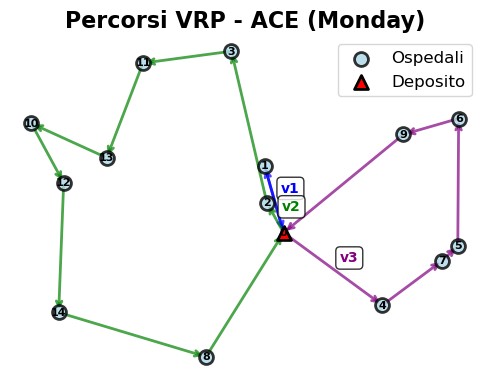

  Distanza Totale per ACE: 16753.10
  Veicoli usati: 3
  Percorsi Dettagliati:
    - Veicolo v1 (Capacità: 3200):
      Percorso (Archi): [(0, 1), (1, 0)]
      Nodi Sequenza: [0, 1, 0]
    - Veicolo v2 (Capacità: 3200):
      Percorso (Archi): [(0, 2), (2, 3), (3, 11), (11, 13), (13, 10), (10, 12), (12, 14), (14, 8), (8, 0)]
      Nodi Sequenza: [0, 2, 3, 11, 13, 10, 12, 14, 8, 0]
    - Veicolo v3 (Capacità: 3200):
      Percorso (Archi): [(0, 4), (4, 7), (7, 5), (5, 6), (6, 9), (9, 0)]
      Nodi Sequenza: [0, 4, 7, 5, 6, 9, 0]

---------------------------------------------
--- Categoria Rifiuto: B ---
---------------------------------------------
  Domanda giornaliera B (attuale): 120.70 kg
  Domanda B accumulata (precedente): 0.00 kg
  Domanda B totale (effettiva): 120.70 kg
  Domanda B totale (120.70 kg) non supera la soglia di 200.0 kg. Non si ritira oggi. Accumulo per domani.

---------------------------------------------
--- Categoria Rifiuto: D ---
----------------------------

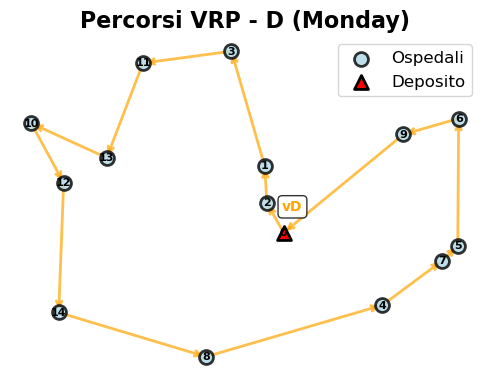

  Distanza Totale per D: 14531.21
  Veicoli usati: 1
  Percorsi Dettagliati:
    - Veicolo vD (Capacità: 3900):
      Percorso (Archi): [(0, 2), (2, 1), (1, 3), (3, 11), (11, 13), (13, 10), (10, 12), (12, 14), (14, 8), (8, 4), (4, 7), (7, 5), (5, 6), (6, 9), (9, 0)]
      Nodi Sequenza: [0, 2, 1, 3, 11, 13, 10, 12, 14, 8, 4, 7, 5, 6, 9, 0]

| RISOLUZIONE PER: TUESDAY                       |

---------------------------------------------
--- Categoria Rifiuto: ACE ---
---------------------------------------------

Solution found!
Total Objective Value: 16753.098962007083

=== PLOTTANDO PERCORSI PER ACE - Tuesday ===


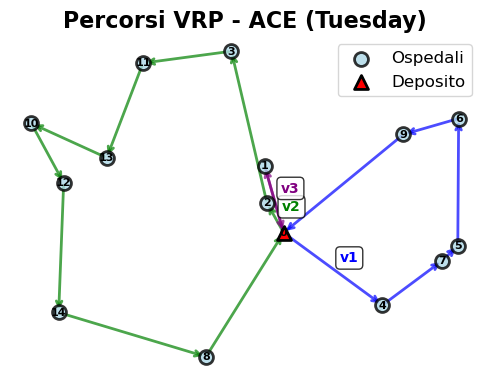

  Distanza Totale per ACE: 16753.10
  Veicoli usati: 3
  Percorsi Dettagliati:
    - Veicolo v1 (Capacità: 3200):
      Percorso (Archi): [(0, 4), (4, 7), (7, 5), (5, 6), (6, 9), (9, 0)]
      Nodi Sequenza: [0, 4, 7, 5, 6, 9, 0]
    - Veicolo v2 (Capacità: 3200):
      Percorso (Archi): [(0, 2), (2, 3), (3, 11), (11, 13), (13, 10), (10, 12), (12, 14), (14, 8), (8, 0)]
      Nodi Sequenza: [0, 2, 3, 11, 13, 10, 12, 14, 8, 0]
    - Veicolo v3 (Capacità: 3200):
      Percorso (Archi): [(0, 1), (1, 0)]
      Nodi Sequenza: [0, 1, 0]

---------------------------------------------
--- Categoria Rifiuto: B ---
---------------------------------------------
  Domanda giornaliera B (attuale): 131.62 kg
  Domanda B accumulata (precedente): 120.70 kg
  Domanda B totale (effettiva): 252.32 kg
  Domanda B totale (252.32 kg) supera la soglia. Si procede al ritiro.

Solution found!
Total Objective Value: 14531.211025640065

=== PLOTTANDO PERCORSI PER B - Tuesday ===


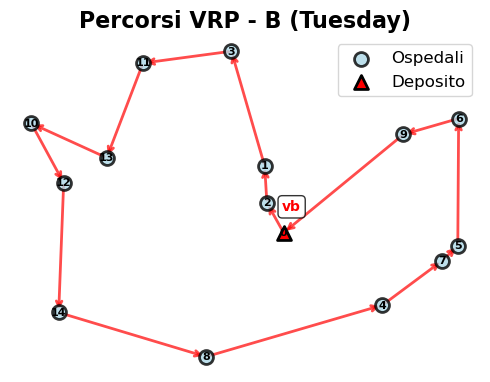

  Distanza Totale per B: 14531.21
  Veicoli usati: 1
  Percorsi Dettagliati:
    - Veicolo vb (Capacità: 1600):
      Percorso (Archi): [(0, 2), (2, 1), (1, 3), (3, 11), (11, 13), (13, 10), (10, 12), (12, 14), (14, 8), (8, 4), (4, 7), (7, 5), (5, 6), (6, 9), (9, 0)]
      Nodi Sequenza: [0, 2, 1, 3, 11, 13, 10, 12, 14, 8, 4, 7, 5, 6, 9, 0]

---------------------------------------------
--- Categoria Rifiuto: D ---
---------------------------------------------

Solution found!
Total Objective Value: 14531.211025640065

=== PLOTTANDO PERCORSI PER D - Tuesday ===


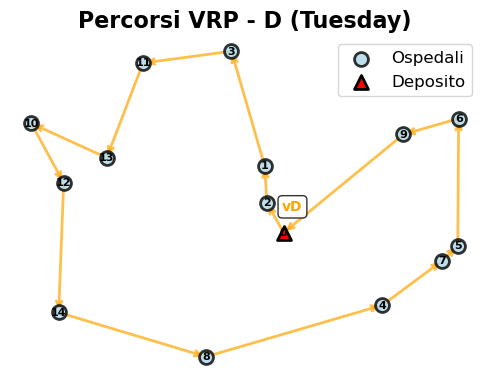

  Distanza Totale per D: 14531.21
  Veicoli usati: 1
  Percorsi Dettagliati:
    - Veicolo vD (Capacità: 3900):
      Percorso (Archi): [(0, 2), (2, 1), (1, 3), (3, 11), (11, 13), (13, 10), (10, 12), (12, 14), (14, 8), (8, 4), (4, 7), (7, 5), (5, 6), (6, 9), (9, 0)]
      Nodi Sequenza: [0, 2, 1, 3, 11, 13, 10, 12, 14, 8, 4, 7, 5, 6, 9, 0]

| RISOLUZIONE PER: WEDNESDAY                     |

---------------------------------------------
--- Categoria Rifiuto: ACE ---
---------------------------------------------

Solution found!
Total Objective Value: 16753.098962007083

=== PLOTTANDO PERCORSI PER ACE - Wednesday ===


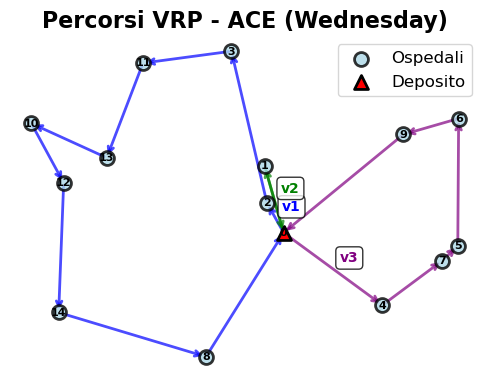

  Distanza Totale per ACE: 16753.10
  Veicoli usati: 3
  Percorsi Dettagliati:
    - Veicolo v1 (Capacità: 3200):
      Percorso (Archi): [(0, 2), (2, 3), (3, 11), (11, 13), (13, 10), (10, 12), (12, 14), (14, 8), (8, 0)]
      Nodi Sequenza: [0, 2, 3, 11, 13, 10, 12, 14, 8, 0]
    - Veicolo v2 (Capacità: 3200):
      Percorso (Archi): [(0, 1), (1, 0)]
      Nodi Sequenza: [0, 1, 0]
    - Veicolo v3 (Capacità: 3200):
      Percorso (Archi): [(0, 4), (4, 7), (7, 5), (5, 6), (6, 9), (9, 0)]
      Nodi Sequenza: [0, 4, 7, 5, 6, 9, 0]

---------------------------------------------
--- Categoria Rifiuto: B ---
---------------------------------------------
  Domanda giornaliera B (attuale): 122.50 kg
  Domanda B accumulata (precedente): 0.00 kg
  Domanda B totale (effettiva): 122.50 kg
  Domanda B totale (122.50 kg) non supera la soglia di 200.0 kg. Non si ritira oggi. Accumulo per domani.

---------------------------------------------
--- Categoria Rifiuto: D ---
----------------------------

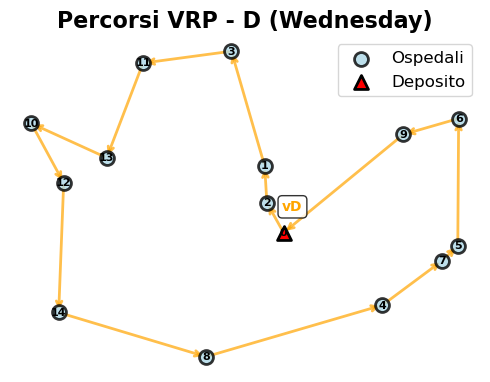

  Distanza Totale per D: 14531.21
  Veicoli usati: 1
  Percorsi Dettagliati:
    - Veicolo vD (Capacità: 3900):
      Percorso (Archi): [(0, 2), (2, 1), (1, 3), (3, 11), (11, 13), (13, 10), (10, 12), (12, 14), (14, 8), (8, 4), (4, 7), (7, 5), (5, 6), (6, 9), (9, 0)]
      Nodi Sequenza: [0, 2, 1, 3, 11, 13, 10, 12, 14, 8, 4, 7, 5, 6, 9, 0]

| RISOLUZIONE PER: THURSDAY                      |

---------------------------------------------
--- Categoria Rifiuto: ACE ---
---------------------------------------------

Solution found!
Total Objective Value: 16753.098962007083

=== PLOTTANDO PERCORSI PER ACE - Thursday ===


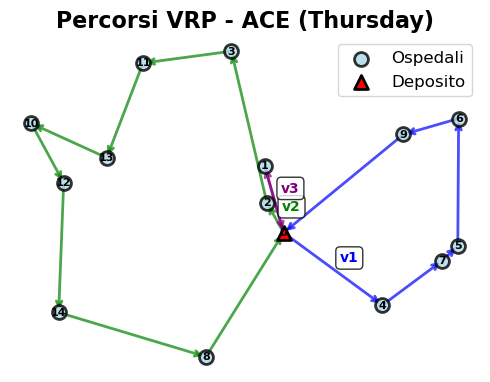

  Distanza Totale per ACE: 16753.10
  Veicoli usati: 3
  Percorsi Dettagliati:
    - Veicolo v1 (Capacità: 3200):
      Percorso (Archi): [(0, 4), (4, 7), (7, 5), (5, 6), (6, 9), (9, 0)]
      Nodi Sequenza: [0, 4, 7, 5, 6, 9, 0]
    - Veicolo v2 (Capacità: 3200):
      Percorso (Archi): [(0, 2), (2, 3), (3, 11), (11, 13), (13, 10), (10, 12), (12, 14), (14, 8), (8, 0)]
      Nodi Sequenza: [0, 2, 3, 11, 13, 10, 12, 14, 8, 0]
    - Veicolo v3 (Capacità: 3200):
      Percorso (Archi): [(0, 1), (1, 0)]
      Nodi Sequenza: [0, 1, 0]

---------------------------------------------
--- Categoria Rifiuto: B ---
---------------------------------------------
  Domanda giornaliera B (attuale): 116.89 kg
  Domanda B accumulata (precedente): 122.50 kg
  Domanda B totale (effettiva): 239.39 kg
  Domanda B totale (239.39 kg) supera la soglia. Si procede al ritiro.

Solution found!
Total Objective Value: 14531.211025640065

=== PLOTTANDO PERCORSI PER B - Thursday ===


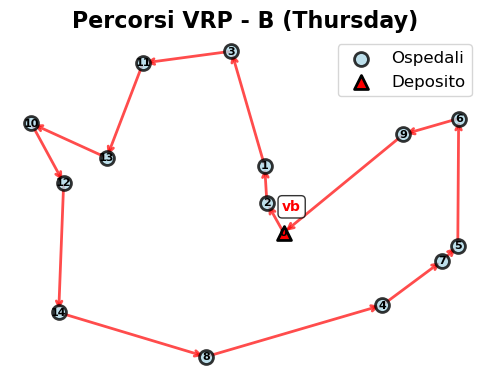

  Distanza Totale per B: 14531.21
  Veicoli usati: 1
  Percorsi Dettagliati:
    - Veicolo vb (Capacità: 1600):
      Percorso (Archi): [(0, 2), (2, 1), (1, 3), (3, 11), (11, 13), (13, 10), (10, 12), (12, 14), (14, 8), (8, 4), (4, 7), (7, 5), (5, 6), (6, 9), (9, 0)]
      Nodi Sequenza: [0, 2, 1, 3, 11, 13, 10, 12, 14, 8, 4, 7, 5, 6, 9, 0]

---------------------------------------------
--- Categoria Rifiuto: D ---
---------------------------------------------

Solution found!
Total Objective Value: 14531.211025640065

=== PLOTTANDO PERCORSI PER D - Thursday ===


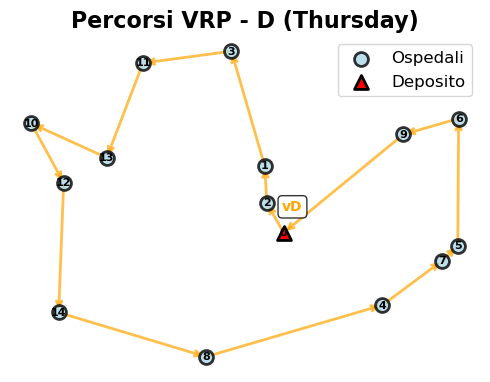

  Distanza Totale per D: 14531.21
  Veicoli usati: 1
  Percorsi Dettagliati:
    - Veicolo vD (Capacità: 3900):
      Percorso (Archi): [(0, 2), (2, 1), (1, 3), (3, 11), (11, 13), (13, 10), (10, 12), (12, 14), (14, 8), (8, 4), (4, 7), (7, 5), (5, 6), (6, 9), (9, 0)]
      Nodi Sequenza: [0, 2, 1, 3, 11, 13, 10, 12, 14, 8, 4, 7, 5, 6, 9, 0]

| RISOLUZIONE PER: FRIDAY                        |

---------------------------------------------
--- Categoria Rifiuto: ACE ---
---------------------------------------------

Solution found!
Total Objective Value: 16753.098962007083

=== PLOTTANDO PERCORSI PER ACE - Friday ===


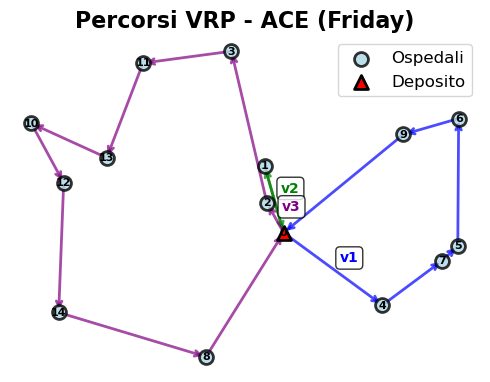

  Distanza Totale per ACE: 16753.10
  Veicoli usati: 3
  Percorsi Dettagliati:
    - Veicolo v1 (Capacità: 3200):
      Percorso (Archi): [(0, 4), (4, 7), (7, 5), (5, 6), (6, 9), (9, 0)]
      Nodi Sequenza: [0, 4, 7, 5, 6, 9, 0]
    - Veicolo v2 (Capacità: 3200):
      Percorso (Archi): [(0, 1), (1, 0)]
      Nodi Sequenza: [0, 1, 0]
    - Veicolo v3 (Capacità: 3200):
      Percorso (Archi): [(0, 2), (2, 3), (3, 11), (11, 13), (13, 10), (10, 12), (12, 14), (14, 8), (8, 0)]
      Nodi Sequenza: [0, 2, 3, 11, 13, 10, 12, 14, 8, 0]

---------------------------------------------
--- Categoria Rifiuto: B ---
---------------------------------------------
  Domanda giornaliera B (attuale): 121.07 kg
  Domanda B accumulata (precedente): 0.00 kg
  Domanda B totale (effettiva): 121.07 kg
  Domanda B totale (121.07 kg) non supera la soglia di 200.0 kg. Non si ritira oggi. Accumulo per domani.

---------------------------------------------
--- Categoria Rifiuto: D ---
----------------------------

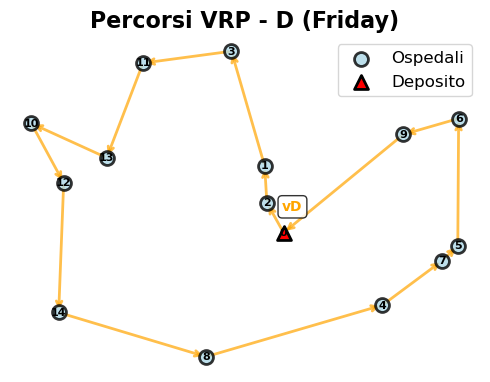

  Distanza Totale per D: 14531.21
  Veicoli usati: 1
  Percorsi Dettagliati:
    - Veicolo vD (Capacità: 3900):
      Percorso (Archi): [(0, 2), (2, 1), (1, 3), (3, 11), (11, 13), (13, 10), (10, 12), (12, 14), (14, 8), (8, 4), (4, 7), (7, 5), (5, 6), (6, 9), (9, 0)]
      Nodi Sequenza: [0, 2, 1, 3, 11, 13, 10, 12, 14, 8, 4, 7, 5, 6, 9, 0]

| RISOLUZIONE PER: SATURDAY                      |

---------------------------------------------
--- Categoria Rifiuto: ACE ---
---------------------------------------------

Solution found!
Total Objective Value: 16058.662087318962

=== PLOTTANDO PERCORSI PER ACE - Saturday ===


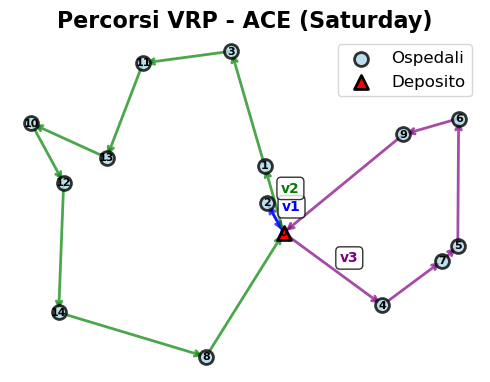

  Distanza Totale per ACE: 16058.66
  Veicoli usati: 3
  Percorsi Dettagliati:
    - Veicolo v1 (Capacità: 3200):
      Percorso (Archi): [(0, 2), (2, 0)]
      Nodi Sequenza: [0, 2, 0]
    - Veicolo v2 (Capacità: 3200):
      Percorso (Archi): [(0, 1), (1, 3), (3, 11), (11, 13), (13, 10), (10, 12), (12, 14), (14, 8), (8, 0)]
      Nodi Sequenza: [0, 1, 3, 11, 13, 10, 12, 14, 8, 0]
    - Veicolo v3 (Capacità: 3200):
      Percorso (Archi): [(0, 4), (4, 7), (7, 5), (5, 6), (6, 9), (9, 0)]
      Nodi Sequenza: [0, 4, 7, 5, 6, 9, 0]

---------------------------------------------
--- Categoria Rifiuto: B ---
---------------------------------------------
  Domanda giornaliera B (attuale): 33.87 kg
  Domanda B accumulata (precedente): 121.07 kg
  Domanda B totale (effettiva): 154.94 kg
  Domanda B totale (154.94 kg) non supera la soglia di 200.0 kg. Non si ritira oggi. Accumulo per domani.

---------------------------------------------
--- Categoria Rifiuto: D ---
---------------------------

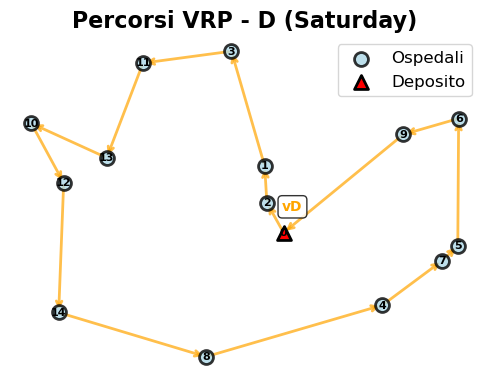

  Distanza Totale per D: 14531.21
  Veicoli usati: 1
  Percorsi Dettagliati:
    - Veicolo vD (Capacità: 3900):
      Percorso (Archi): [(0, 2), (2, 1), (1, 3), (3, 11), (11, 13), (13, 10), (10, 12), (12, 14), (14, 8), (8, 4), (4, 7), (7, 5), (5, 6), (6, 9), (9, 0)]
      Nodi Sequenza: [0, 2, 1, 3, 11, 13, 10, 12, 14, 8, 4, 7, 5, 6, 9, 0]

| RISOLUZIONE PER: SUNDAY                        |

---------------------------------------------
--- Categoria Rifiuto: ACE ---
---------------------------------------------

Solution found!
Total Objective Value: 16058.662087318962

=== PLOTTANDO PERCORSI PER ACE - Sunday ===


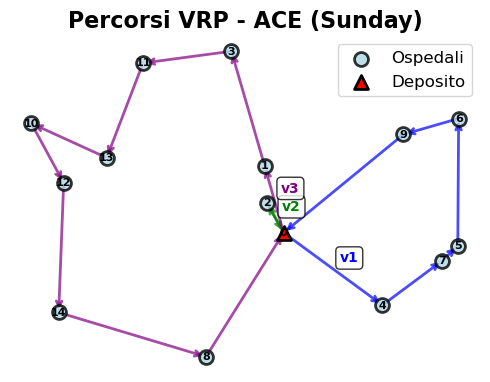

  Distanza Totale per ACE: 16058.66
  Veicoli usati: 3
  Percorsi Dettagliati:
    - Veicolo v1 (Capacità: 3200):
      Percorso (Archi): [(0, 4), (4, 7), (7, 5), (5, 6), (6, 9), (9, 0)]
      Nodi Sequenza: [0, 4, 7, 5, 6, 9, 0]
    - Veicolo v2 (Capacità: 3200):
      Percorso (Archi): [(0, 2), (2, 0)]
      Nodi Sequenza: [0, 2, 0]
    - Veicolo v3 (Capacità: 3200):
      Percorso (Archi): [(0, 1), (1, 3), (3, 11), (11, 13), (13, 10), (10, 12), (12, 14), (14, 8), (8, 0)]
      Nodi Sequenza: [0, 1, 3, 11, 13, 10, 12, 14, 8, 0]

---------------------------------------------
--- Categoria Rifiuto: B ---
---------------------------------------------
  Domanda giornaliera B (attuale): 34.21 kg
  Domanda B accumulata (precedente): 154.94 kg
  Domanda B totale (effettiva): 189.15 kg
  Domanda B totale (189.15 kg) non supera la soglia di 200.0 kg. Non si ritira oggi. Accumulo per domani.

---------------------------------------------
--- Categoria Rifiuto: D ---
---------------------------

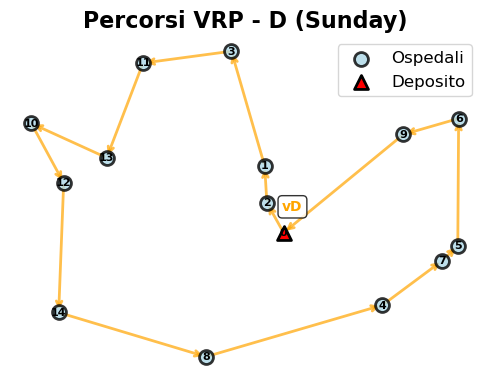

  Distanza Totale per D: 14531.21
  Veicoli usati: 1
  Percorsi Dettagliati:
    - Veicolo vD (Capacità: 3900):
      Percorso (Archi): [(0, 2), (2, 1), (1, 3), (3, 11), (11, 13), (13, 10), (10, 12), (12, 14), (14, 8), (8, 4), (4, 7), (7, 5), (5, 6), (6, 9), (9, 0)]
      Nodi Sequenza: [0, 2, 1, 3, 11, 13, 10, 12, 14, 8, 4, 7, 5, 6, 9, 0]


In [213]:
# LOOP PRINCIPALE E GESTIONE DELLA DOMANDA ACCUMULATA B 
# Inizializzata con 0 per ogni nodo cliente (ce ne sono 14, da Node1 a Node14)
# Assumiamo che i nodi cliente siano nodes[1] a nodes[14].
# La lunghezza di 'demand' è 14, quindi sarà la stessa.
num_customer_nodes = len(nodes) - 1 # Nodi 1-14 
accumulated_b_demand_per_node = [0.0] * num_customer_nodes #Crea una lista per tenere traccia dei rifiuti B accumulati in ogni ospedale

# Costante per la soglia
B_DEMAND_THRESHOLD_KG = 200.0

for day_idx, day_name in enumerate(days_of_week):#Itera su ogni giorno da lunedì a domenica.
    print(f"\n{'='*50}")
    print(f"| {'RISOLUZIONE PER: ' + day_name.upper():<46} |")
    print(f"{'='*50}")
    current_day_demands = all_days_demands_list[day_idx]
    
    all_periodic_solutions[day_name] = {}

    for waste_type in ['ACE', 'B', 'D']: #Per ogni giorno, considera tutti e 3 i tipi di rifiuto.
        print(f"\n{'---'*15}")
        print(f"--- Categoria Rifiuto: {waste_type} ---")
        print(f"{'---'*15}")
        
        current_demands_list_for_waste_type = current_day_demands[waste_type]
        current_vehicles_names = vehicle_data[waste_type]['vehicles']
        current_vehicles_capacities = vehicle_data[waste_type]['capacity']

        # --- LOGICA SPECIFICA PER I RIFIUTI TIPO 'B' ---
        if waste_type == 'B':
            # Calcola la domanda "effettiva" di B per questo giorno (domanda del giorno + accumulo)
            effective_b_demand_for_today = [
                current_demands_list_for_waste_type[i] + accumulated_b_demand_per_node[i]
                for i in range(num_customer_nodes)
            ]
            
            total_effective_b_demand = sum(effective_b_demand_for_today)
            
            print(f"  Domanda giornaliera B (attuale): {sum(current_demands_list_for_waste_type):.2f} kg")
            print(f"  Domanda B accumulata (precedente): {sum(accumulated_b_demand_per_node):.2f} kg")
            print(f"  Domanda B totale (effettiva): {total_effective_b_demand:.2f} kg")

            if total_effective_b_demand <= B_DEMAND_THRESHOLD_KG:
                message = (f"Domanda B totale ({total_effective_b_demand:.2f} kg) non supera la soglia di {B_DEMAND_THRESHOLD_KG} kg. "
                           f"Non si ritira oggi. Accumulo per domani.")
                print(f"  {message}")
                
                # Accumula la domanda attuale per il giorno dopo (non resetta l'accumulo precedente)
                accumulated_b_demand_per_node = effective_b_demand_for_today # Tutto ciò che era in effective_b_demand_for_today ora si accumula

                total_dist = 0.0 # Nessun percorso fatto, quindi distanza 0
                all_periodic_solutions[day_name][waste_type] = {
                    'routes': {},
                    'nodes_in_order': {},
                    'total_distance': total_dist,
                    'message': message
                }
                summary_data.append([day_name, waste_type, total_dist, 0, "Accumulata"])
                continue # Passa al prossimo tipo di rifiuto
            else:
                print(f"  Domanda B totale ({total_effective_b_demand:.2f} kg) supera la soglia. Si procede al ritiro.")
                # Usa la domanda effettiva per la risoluzione VRP
                current_demands_list_for_waste_type = effective_b_demand_for_today
                # Reset della domanda accumulata dopo la risoluzione (presumendo che venga raccolta)
                accumulated_b_demand_per_node = [0.0] * num_customer_nodes
        # --- FINE LOGICA SPECIFICA PER I RIFIUTI TIPO 'B' ---


        # Controlli generali di validità (validi per tutti i tipi di rifiuto, inclusi B se la soglia è superata)
        if not current_demands_list_for_waste_type or all(d == 0 for d in current_demands_list_for_waste_type):
            message = f"Nessuna domanda per {waste_type} in {day_name}. Salto la risoluzione."
            total_dist = 0.0
            print(f"  {message}")
            all_periodic_solutions[day_name][waste_type] = {
                'routes': {},
                'nodes_in_order': {},
                'total_distance': total_dist,
                'message': message
            }
            summary_data.append([day_name, waste_type, total_dist, 0, "Nessuna Domanda"])
            continue

        if not current_vehicles_names:
            message = f"Nessun veicolo disponibile per {waste_type}. Salto la risoluzione."
            total_dist = float('inf')
            print(f"  {message}")
            all_periodic_solutions[day_name][waste_type] = {
                'routes': {},
                'nodes_in_order': {},
                'total_distance': total_dist,
                'message': message
            }
            summary_data.append([day_name, waste_type, total_dist, 0, "Nessun Veicolo"])
            continue

        ### APPLICAZIONE DEL RISOLUTORE
        try:
            routes, ordered_nodes, total_dist = solve_vrp(
                nodes,
                cost_matrix,
                current_demands_list_for_waste_type, # Passa la domanda (effettiva per B, altrimenti normale)
                current_vehicles_names,
                current_vehicles_capacities
            )
            
            if routes is not None: # se una soluzione è trovata allora si salvano e si stampano i risultati
                plot_single_waste_type(all_nodes_gdf, routes, waste_type, day_name)
                num_vehicles_used = len([v for v, p in routes.items() if p]) # Conta solo i veicoli con un percorso
                all_periodic_solutions[day_name][waste_type] = {
                    'routes': routes,
                    'nodes_in_order': ordered_nodes,
                    'total_distance': total_dist,
                    'message': "Soluzione trovata"
                }
                print(f"  Distanza Totale per {waste_type}: {total_dist:.2f}")
                print(f"  Veicoli usati: {num_vehicles_used}")
                print(f"  Percorsi Dettagliati:")
                
                for vehicle_name in current_vehicles_names: # Itera su tutti i veicoli possibili per questo tipo
                    path = routes.get(vehicle_name, [])
                    nodes_path = ordered_nodes.get(vehicle_name, [])

                    if path: # Stampa solo se il veicolo è stato utilizzato
                        print(f"    - Veicolo {vehicle_name} (Capacità: {vehicle_data[waste_type]['capacity'][current_vehicles_names.index(vehicle_name)]}):")
                        # Percorso e Nodi per la stampa, qui ho lasciato l'output più compatto
                        print(f"      Percorso (Archi): {path}")
                        print(f"      Nodi Sequenza: {nodes_path}")
                    # else: non stampiamo nulla se il veicolo non è stato usato per non avere output ridondante
                
                summary_data.append([day_name, waste_type, total_dist, num_vehicles_used, "Ottimale"])
            else:
                message = f"Impossibile trovare soluzione ottimale per {waste_type}."
                total_dist = float('inf')
                print(f"  {message}")
                all_periodic_solutions[day_name][waste_type] = {
                    'routes': {},
                    'nodes_in_order': {},
                    'total_distance': total_dist,
                    'message': message
                }
                summary_data.append([day_name, waste_type, total_dist, 0, "Non Trovata"])

        except Exception as e:
            message = f"Errore durante la risoluzione per {waste_type}: {e}"
            total_dist = float('inf')
            print(f"  [ERRORE GENERALE] {message}")
            all_periodic_solutions[day_name][waste_type] = {
                'routes': {},
                'nodes_in_order': {},
                'total_distance': total_dist,
                'message': message
            }
            summary_data.append([day_name, waste_type, total_dist, 0, "Errore di Runtime"])

In [214]:
# --- Riepilogo Finale in Tabella ---
print(f"\n\n{'='*70}")
print(f"| {'RIEPILOGO GENERALE DELLE SOLUZIONI':<66} |")
print(f"{'='*70}")

if summary_data:
    df_summary = pd.DataFrame(summary_data, columns=['Giorno', 'Tipo Rifiuto', 'Distanza Totale (secondi)', 'Veicoli Usati', 'Stato Soluzione'])
    
    # Formatta la colonna Distanza Totale per una migliore leggibilità
    df_summary['Distanza Totale (secondi)'] = df_summary['Distanza Totale (secondi)'].apply(
        lambda x: str(x)
    ) # Converti in stringa per gestire N/A e float
    
    print(df_summary.to_string(index=False))
else:
    print("Nessun dato di riepilogo disponibile.")

print(f"\n{'='*70}")



| RIEPILOGO GENERALE DELLE SOLUZIONI                                 |
   Giorno Tipo Rifiuto Distanza Totale (secondi)  Veicoli Usati Stato Soluzione
   Monday          ACE        16753.098962007083              3        Ottimale
   Monday            B                       0.0              0      Accumulata
   Monday            D        14531.211025640065              1        Ottimale
  Tuesday          ACE        16753.098962007083              3        Ottimale
  Tuesday            B        14531.211025640065              1        Ottimale
  Tuesday            D        14531.211025640065              1        Ottimale
Wednesday          ACE        16753.098962007083              3        Ottimale
Wednesday            B                       0.0              0      Accumulata
Wednesday            D        14531.211025640065              1        Ottimale
 Thursday          ACE        16753.098962007083              3        Ottimale
 Thursday            B        14531.21102564006